#### Point the filePath to where you have downloaded the datasets to and
#### assign the data files to data.tables
over to you! fill in the path to your working directory. If you are on a Windows
machine, you will need to use forward slashes (/) instead of backshashes (\)

In [441]:
# Point the filePath to where you have downloaded the datasets to and
# assign the data files to data.tables

import pandas as pd
import numpy as np
import regex as re
from plotnine import *
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

transactionData = pd.read_excel("QVI_transaction_data.xlsx")
customerData = pd.read_csv("QVI_purchase_behaviour.csv")

### Exploratory data analysis
#The first step in any analysis is to first understand the data. Let's take a look
#at each of the datasets provided.

### Examining transaction and customer data
We can use `str()` to look at the format of each column and see a sample of the
data. As we have read in the dataset as a `data.table` object, we can also run
`transactionData` in the console to see a sample of the data or use
`head(transactionData)` to look at the first 10 rows.

In [442]:
#first ten observations of transaction Data
transactionData.head(10)

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8
5,43604,4,4074,2982,57,Old El Paso Salsa Dip Tomato Mild 300g,1,5.1
6,43601,4,4149,3333,16,Smiths Crinkle Chips Salt & Vinegar 330g,1,5.7
7,43601,4,4196,3539,24,Grain Waves Sweet Chilli 210g,1,3.6
8,43332,5,5026,4525,42,Doritos Corn Chip Mexican Jalapeno 150g,1,3.9
9,43330,7,7150,6900,52,Grain Waves Sour Cream&Chives 210G,2,7.2


We see multiple variables including numeric, string, and factor variables, meaning efficient grouping is required for analysis.

In [443]:
#first ten observations of customer Data
customerData.head(10)

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream
5,1007,YOUNG SINGLES/COUPLES,Budget
6,1009,NEW FAMILIES,Premium
7,1010,YOUNG SINGLES/COUPLES,Mainstream
8,1011,OLDER SINGLES/COUPLES,Mainstream
9,1012,OLDER FAMILIES,Mainstream


We see factor variables: 'LIFESTAGE' and 'PREMIUM_CUSTOMER'. Since we have 'LYLTY_CARD_NBR' variable in common in both data, we can merge two data sets.

In [444]:
#see variable types
customerData.dtypes

LYLTY_CARD_NBR       int64
LIFESTAGE           object
PREMIUM_CUSTOMER    object
dtype: object

In [445]:
#see variable types
transactionData.dtypes

DATE                int64
STORE_NBR           int64
LYLTY_CARD_NBR      int64
TXN_ID              int64
PROD_NBR            int64
PROD_NAME          object
PROD_QTY            int64
TOT_SALES         float64
dtype: object

We can see that the date column is in an integer format. Let's change this to a date format.

In [446]:
#Convert DATE column to a date format
transactionData['DATE'] = pd.to_datetime(transactionData['DATE'], origin = "1899-12-30", unit = "D")

A quick search online tells us that CSV and Excel integer dates begin on 30 Dec 1899

In [447]:
#check if applied correctly
transactionData['DATE']

0        2018-10-17
1        2019-05-14
2        2019-05-20
3        2018-08-17
4        2018-08-18
            ...    
264831   2019-03-09
264832   2018-08-13
264833   2018-11-06
264834   2018-12-27
264835   2018-09-22
Name: DATE, Length: 264836, dtype: datetime64[ns]

#### Examine PROD_NAME

Looks like we are definitely looking at potato chips but how can we check that
these are all chips? We can do some basic text analysis by summarising the
individual words in the product name.

In [448]:
transactionData['PROD_NAME']

0           Natural Chip        Compny SeaSalt175g
1                         CCs Nacho Cheese    175g
2           Smiths Crinkle Cut  Chips Chicken 170g
3           Smiths Chip Thinly  S/Cream&Onion 175g
4         Kettle Tortilla ChpsHny&Jlpno Chili 150g
                            ...                   
264831     Kettle Sweet Chilli And Sour Cream 175g
264832               Tostitos Splash Of  Lime 175g
264833                    Doritos Mexicana    170g
264834     Doritos Corn Chip Mexican Jalapeno 150g
264835               Tostitos Splash Of  Lime 175g
Name: PROD_NAME, Length: 264836, dtype: object

In [449]:
#see how many unique products we have
transactionData['PROD_NAME'].nunique

<bound method IndexOpsMixin.nunique of 0           Natural Chip        Compny SeaSalt175g
1                         CCs Nacho Cheese    175g
2           Smiths Crinkle Cut  Chips Chicken 170g
3           Smiths Chip Thinly  S/Cream&Onion 175g
4         Kettle Tortilla ChpsHny&Jlpno Chili 150g
                            ...                   
264831     Kettle Sweet Chilli And Sour Cream 175g
264832               Tostitos Splash Of  Lime 175g
264833                    Doritos Mexicana    170g
264834     Doritos Corn Chip Mexican Jalapeno 150g
264835               Tostitos Splash Of  Lime 175g
Name: PROD_NAME, Length: 264836, dtype: object>

#### Examine the words in PROD_NAME to see if there are any incorrect entries
#### such as products that are not chips

As we are only interested in words that will tell us if the product is chips or
not, let's remove all words with digits and special characters such as '&' from our
set of product words.

In [450]:
#see if the variable contains special character
transactionData['PROD_NAME'].str.contains('&')

0         False
1         False
2         False
3          True
4          True
          ...  
264831    False
264832    False
264833    False
264834    False
264835    False
Name: PROD_NAME, Length: 264836, dtype: bool

In [451]:
#chracters to replace
char_to_replace = ('&','*','/','@','#','$','%','^','*','(',')','-','_','=','+','?',',',';',':','\'','\"','<','>','[',']','{','}')

In [520]:
#delete all the speical characters

#prodName = transactionData.PROD_NAME
#for  i in range(len(prodName)):
#    for j in char_to_replace:
#        if j in transactionData.PROD_NAME[i]:
#            prodName[i] = transactionData.PROD_NAME[i].replace(j, " ")
#            prodName.head(10)

transactionData.PROD_NAME.str.replace('&', ' ').replace(r'\/', ' ')

0           Natural Chip        Compny SeaSalt175g
1                         CCs Nacho Cheese    175g
2           Smiths Crinkle Cut  Chips Chicken 170g
3           Smiths Chip Thinly  S/Cream Onion 175g
4         Kettle Tortilla ChpsHny Jlpno Chili 150g
                            ...                   
264831     Kettle Sweet Chilli And Sour Cream 175g
264832               Tostitos Splash Of  Lime 175g
264833                    Doritos Mexicana    170g
264834     Doritos Corn Chip Mexican Jalapeno 150g
264835               Tostitos Splash Of  Lime 175g
Name: PROD_NAME, Length: 246740, dtype: object

Since for loop causes programming runnning time longer and I found out that '&' and '/' are the only special characters I could observe. Therefore, I'll use simpler method.

In [453]:
#count all the unique items

prodName.value_counts()

Kettle Mozzarella   Basil   Pesto 175g      3304
Kettle Tortilla ChpsHny Jlpno Chili 150g    3296
Cobs Popd Swt Chlli  Sr Cream Chips 110g    3269
Tyrrells Crisps     Ched   Chives 165g      3268
Cobs Popd Sea Salt  Chips 110g              3265
                                            ... 
RRD Pc Sea Salt     165g                    1431
Woolworths Medium   Salsa 300g              1430
NCC Sour Cream      Garden Chives 175g      1419
French Fries Potato Chips 175g              1418
WW Crinkle Cut      Original 175g           1410
Name: PROD_NAME, Length: 114, dtype: int64

There are salsa products in the dataset but we are only interested in the chips
category, so let's remove these.

In [454]:
#print without Salsa products

transactionData = transactionData[-transactionData['PROD_NAME'].str.contains('Salsa')]

In [455]:
transactionData.head(10)

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8
6,2019-05-16,4,4149,3333,16,Smiths Crinkle Chips Salt & Vinegar 330g,1,5.7
7,2019-05-16,4,4196,3539,24,Grain Waves Sweet Chilli 210g,1,3.6
8,2018-08-20,5,5026,4525,42,Doritos Corn Chip Mexican Jalapeno 150g,1,3.9
9,2018-08-18,7,7150,6900,52,Grain Waves Sour Cream&Chives 210G,2,7.2
10,2019-05-17,7,7215,7176,16,Smiths Crinkle Chips Salt & Vinegar 330g,1,5.7


In [456]:
#see if there is any outliers

transactionData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 246742 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   DATE            246742 non-null  datetime64[ns]
 1   STORE_NBR       246742 non-null  int64         
 2   LYLTY_CARD_NBR  246742 non-null  int64         
 3   TXN_ID          246742 non-null  int64         
 4   PROD_NBR        246742 non-null  int64         
 5   PROD_NAME       246742 non-null  object        
 6   PROD_QTY        246742 non-null  int64         
 7   TOT_SALES       246742 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(5), object(1)
memory usage: 16.9+ MB


The summary shows there is non-null count, meaning no missing observations.

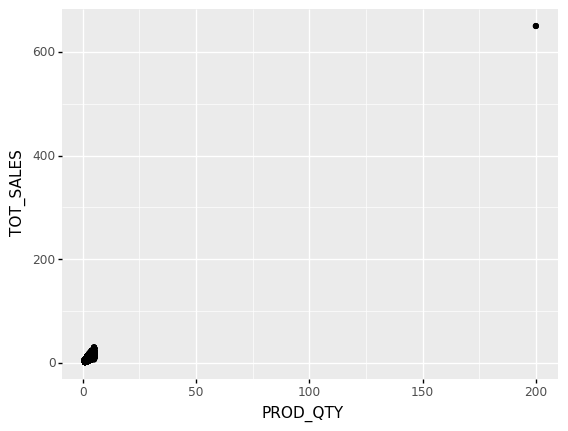

<ggplot: (136680410929)>

In [457]:
#dot graph to see any outliers or patterns
ggplot(transactionData, aes(x = 'PROD_QTY', y = 'TOT_SALES')) + geom_point()

The result shows that there is an outlier where TOT_SALES is around 650 and PROD_QTY is around 200.

In [458]:
#found outliers from ggplot. now find those outliers.

transactionData[transactionData.PROD_QTY == 200]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0


Resulted in observing two outliers that has 650 sales

In [459]:
#identify the purchase history of the same customer

transactionData[-(transactionData.LYLTY_CARD_NBR == 226000)]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8
...,...,...,...,...,...,...,...,...
264831,2019-03-09,272,272319,270088,89,Kettle Sweet Chilli And Sour Cream 175g,2,10.8
264832,2018-08-13,272,272358,270154,74,Tostitos Splash Of Lime 175g,1,4.4
264833,2018-11-06,272,272379,270187,51,Doritos Mexicana 170g,2,8.8
264834,2018-12-27,272,272379,270188,42,Doritos Corn Chip Mexican Jalapeno 150g,2,7.8


In [460]:
#remove outlier customer information out of our data

transactionData = transactionData[-(transactionData.LYLTY_CARD_NBR == 226000)]

In [461]:
#proof of 226000 customer got rid of

transactionData[(transactionData.LYLTY_CARD_NBR == 226000)]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES


It looks like this customer has only had the two transactions over the year and is
not an ordinary retail customer. The customer might be buying chips for commercial
purposes instead. We'll remove this loyalty card number from further analysis.
Since we don't see any observation, we successfully eliminated outliers

In [462]:
#count all transacdtions by dates
countTransaction = transactionData.groupby('DATE').count()
countTransaction

,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
DATE,,,,,,,
2018-07-01,663,663,663,663,663,663,663
2018-07-02,650,650,650,650,650,650,650
2018-07-03,674,674,674,674,674,674,674
2018-07-04,669,669,669,669,669,669,669
2018-07-05,660,660,660,660,660,660,660
...,...,...,...,...,...,...,...
2019-06-26,657,657,657,657,657,657,657
2019-06-27,669,669,669,669,669,669,669
2019-06-28,673,673,673,673,673,673,673


There's only 364 rows, meaning only 364 dates which indicates a missing date. Let's
create a sequence of dates from 1 Jul 2018 to 30 Jun 2019 and use this to create a
chart of number of transactions over time to find the missing date.

In [463]:
#find missing dates
pd.date_range(start = '2018-07-01', end = '2019-06-30').difference(countTransaction.index)

DatetimeIndex(['2018-12-25'], dtype='datetime64[ns]', freq=None)

In [464]:
#add missing date and values to the row
countTransaction.loc['2018-12-25'] = 0

In [465]:
#move back 'DATE' index back to data set and sort by Date.
countTransaction = countTransaction.reset_index().sort_values('DATE')

In [466]:
#check if DATE label is returned to a variable
countTransaction.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 365 entries, 0 to 363
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   DATE            365 non-null    datetime64[ns]
 1   STORE_NBR       365 non-null    int64         
 2   LYLTY_CARD_NBR  365 non-null    int64         
 3   TXN_ID          365 non-null    int64         
 4   PROD_NBR        365 non-null    int64         
 5   PROD_NAME       365 non-null    int64         
 6   PROD_QTY        365 non-null    int64         
 7   TOT_SALES       365 non-null    int64         
dtypes: datetime64[ns](1), int64(7)
memory usage: 25.7 KB


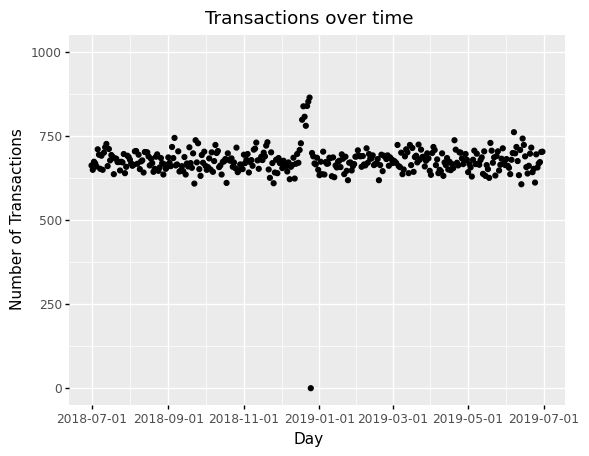

<ggplot: (136681193177)>

In [467]:
#show transactions per month graph
(
    ggplot(countTransaction)
    + aes(x = 'DATE', y = 'TOT_SALES')
    + geom_point()
    + labs(x = "Day", y = "Number of Transactions", title = "Transactions over time")
    + ylim(0, 1000)
    #+ ylim()
    #+ scale_x_date(breaks = '1 month', labels = '%d')
)

The graph shows two 0 values we put due to 0 sales in holidays, and abnormal higher transactions before the holidays.

C:\Users\jang\anaconda3\lib\site-packages\plotnine\geoms\geom_path.py:75: PlotnineWarning: geom_path: Removed 334 rows containing missing values.


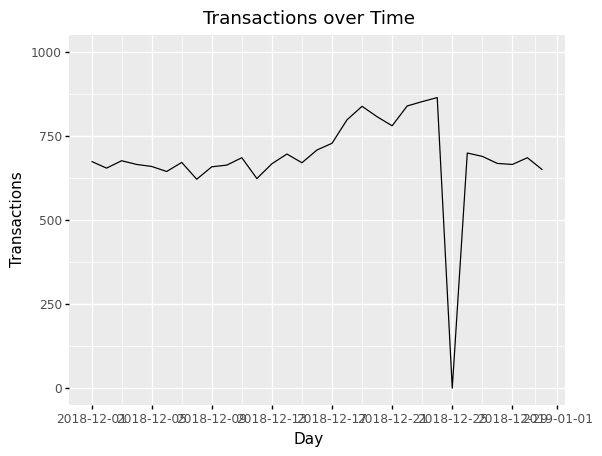

<ggplot: (136680292566)>

In [468]:
#look closer between dec 01 - dec 31
(
    ggplot(countTransaction)
    + aes(x = 'DATE', y = 'TOT_SALES')
    + geom_line()
    + labs(x = "Day", y = "Transactions", title = "Transactions over Time")
    + ylim(0, 1000)
    #+ xlim('2018-12-01', '2018-12-31')
    + scale_x_date(limits = ('2018-12-01', '2018-12-31'))
)

In [469]:
#extract product weight from PROD_NAME
transactionData["PACK_SIZE"] = transactionData.PROD_NAME.str.extract(r'([0-9]+[gG])')[0].str.replace("[gG]", "").astype("int64")

<ipython-input-469-b381662de2fe>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [470]:
#check if it worked
transactionData.PACK_SIZE.head(10)

0     175
1     175
2     170
3     175
4     150
6     330
7     210
8     150
9     210
10    330
Name: PACK_SIZE, dtype: int64

In [471]:
#try to create Weight variable with different methods.

#transactionData.Weight = transactionData.PROD_NAME.str.extract(pat = r'[0-9][0-9][0-9][gG]')
#splitted = transactionData.PROD_NAME.str.split(" ")
#takes way too long time to run. need better suggestion.
#create Weight variable by dividing product name and the weight from PROD_NAME

#    transactionData.PACK_SIZE = splitted[i][len(splitted[i]) - 1]

C:\Users\jang\anaconda3\lib\site-packages\plotnine\stats\stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 389'. Pick better value with 'binwidth'.


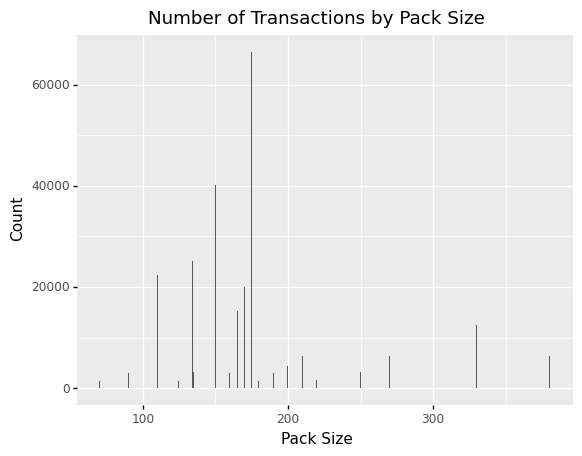

<ggplot: (136696348907)>

In [472]:
#count the total transactins compared by pack sizes.
(
    ggplot(transactionData)
    + aes(x = 'PACK_SIZE')
    + geom_histogram()
    + labs(x = "Pack Size", y = "Count", title = "Number of Transactions by Pack Size")
    
)

In [473]:
#extract brands by splitting first word of each rows
transactionData.Brands = transactionData.PROD_NAME.str.split(r"([A-Z][a-zA-Z]+)", expand=True)[1]
transactionData.Brands.head(10)

<ipython-input-473-380aa1883118>:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


0     Natural
1         CCs
2      Smiths
3      Smiths
4      Kettle
6      Smiths
7       Grain
8     Doritos
9       Grain
10     Smiths
Name: 1, dtype: object

Some of the brand names look like they are of the same brands - such as RED and
RRD, which are both Red Rock Deli chips. Let's combine these together.

In [474]:
#Clean brand names
transactionData.Brands.replace("RED", "RRD")

0          Natural
1              CCs
2           Smiths
3           Smiths
4           Kettle
            ...   
264831      Kettle
264832    Tostitos
264833     Doritos
264834     Doritos
264835    Tostitos
Name: 1, Length: 246740, dtype: object

In [475]:
#check if it's done right
[col for col in transactionData.Brands if 'RED' in col]

[]

In [476]:
#find names that should be changed
sorted(transactionData.Brands.unique())

['Burger',
 'CCs',
 'Cheetos',
 'Cheezels',
 'Cobs',
 'Dorito',
 'Doritos',
 'French',
 'Grain',
 'GrnWves',
 'Infuzions',
 'Infzns',
 'Kettle',
 'NCC',
 'Natural',
 'Pringles',
 'RRD',
 'Red',
 'Smith',
 'Smiths',
 'Snbts',
 'Sunbites',
 'Thins',
 'Tostitos',
 'Twisties',
 'Tyrrells',
 'WW',
 'Woolworths']

In [477]:
#fix brand names
brandName = {
             'Red':'RRD',
             'Dorito':'Doritos',
             'Infzns':'Infuzions',
             'Smith':'Smiths',
             'Snbts':'Sunbites',
             'WW':'Woolworths'
            }

def clean_name(val):
    if val in brandName:
        return brandName[val]
    else:
        return val
    
transactionData.Brands = transactionData.Brands.apply(clean_name)

In [478]:
#check if applied appropriately
transactionData.Brands.unique()

array(['Natural', 'CCs', 'Smiths', 'Kettle', 'Grain', 'Doritos',
       'Twisties', 'Woolworths', 'Thins', 'Burger', 'NCC', 'Cheezels',
       'Infuzions', 'RRD', 'Pringles', 'GrnWves', 'Tyrrells', 'Cobs',
       'French', 'Tostitos', 'Cheetos', 'Sunbites'], dtype=object)

In [479]:
#exploring customer data
customerData.head(10)

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream
5,1007,YOUNG SINGLES/COUPLES,Budget
6,1009,NEW FAMILIES,Premium
7,1010,YOUNG SINGLES/COUPLES,Mainstream
8,1011,OLDER SINGLES/COUPLES,Mainstream
9,1012,OLDER FAMILIES,Mainstream


In [480]:
#exploring customer data
customerData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72637 entries, 0 to 72636
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   LYLTY_CARD_NBR    72637 non-null  int64 
 1   LIFESTAGE         72637 non-null  object
 2   PREMIUM_CUSTOMER  72637 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [481]:
#checking if all values in LYLTY_CARD_NBR are unique
customerData['LYLTY_CARD_NBR'].nunique()

72637

As the number of rows in `customerData` is the same as that of `transactionData`, we can be
sure that no duplicates were created. This is because we created `customerData` by setting
`all.x = TRUE` (in other words, a left join) which means take all the rows in
`transactionData` and find rows with matching values in shared columns and then
joining the details in these rows to the `x` or the first mentioned table.

In [524]:
#merge dataset
mergedData = pd.merge(transactionData, customerData, how='outer')

In [526]:
mergedData = mergedData.dropna()

In [527]:
mergedData.LYLTY_CARD_NBR.nunique()

71287

In [528]:
#check if applied properly
mergedData.head(10)

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,LIFESTAGE,PREMIUM_CUSTOMER
0,2018-10-17,1.0,1000,1.0,5.0,Natural Chip Compny SeaSalt175g,2.0,6.0,175.0,YOUNG SINGLES/COUPLES,Premium
1,2019-05-14,1.0,1307,348.0,66.0,CCs Nacho Cheese 175g,3.0,6.3,175.0,MIDAGE SINGLES/COUPLES,Budget
2,2018-11-10,1.0,1307,346.0,96.0,WW Original Stacked Chips 160g,2.0,3.8,160.0,MIDAGE SINGLES/COUPLES,Budget
3,2019-03-09,1.0,1307,347.0,54.0,CCs Original 175g,1.0,2.1,175.0,MIDAGE SINGLES/COUPLES,Budget
4,2019-05-20,1.0,1343,383.0,61.0,Smiths Crinkle Cut Chips Chicken 170g,2.0,2.9,170.0,MIDAGE SINGLES/COUPLES,Budget
5,2018-08-17,2.0,2373,974.0,69.0,Smiths Chip Thinly S/Cream Onion 175g,5.0,15.0,175.0,MIDAGE SINGLES/COUPLES,Budget
6,2018-08-18,2.0,2426,1038.0,108.0,Kettle Tortilla ChpsHny Jlpno Chili 150g,3.0,13.8,150.0,MIDAGE SINGLES/COUPLES,Budget
7,2019-05-16,4.0,4149,3333.0,16.0,Smiths Crinkle Chips Salt Vinegar 330g,1.0,5.7,330.0,MIDAGE SINGLES/COUPLES,Budget
8,2018-07-06,4.0,4149,3330.0,46.0,Kettle Original 175g,2.0,10.8,175.0,MIDAGE SINGLES/COUPLES,Budget
9,2018-07-18,4.0,4149,3331.0,112.0,Tyrrells Crisps Ched Chives 165g,2.0,8.4,165.0,MIDAGE SINGLES/COUPLES,Budget


In [529]:
#check for null
mergedData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 246740 entries, 0 to 246739
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   DATE              246740 non-null  datetime64[ns]
 1   STORE_NBR         246740 non-null  float64       
 2   LYLTY_CARD_NBR    246740 non-null  int64         
 3   TXN_ID            246740 non-null  float64       
 4   PROD_NBR          246740 non-null  float64       
 5   PROD_NAME         246740 non-null  object        
 6   PROD_QTY          246740 non-null  float64       
 7   TOT_SALES         246740 non-null  float64       
 8   PACK_SIZE         246740 non-null  float64       
 9   LIFESTAGE         246740 non-null  object        
 10  PREMIUM_CUSTOMER  246740 non-null  object        
dtypes: datetime64[ns](1), float64(6), int64(1), object(3)
memory usage: 22.6+ MB


In [486]:
#save file for task 2
mergedData.to_csv('QVI_data.csv')

## Data analysis on customer segments
Now that the data is ready for analysis, we can define some metrics of interest to the client:

- Who spends the most on chips (total sales), describing customers by lifestage and how premium their general purchasing behaviour is
- How many customers are in each segment
- How many chips are bought per customer by segment
- What's the average chip price by customer segment

We could also ask our data team for more information. Examples are:

- The customer's total spend over the period and total spend for each transaction to understand what proportion of their grocery spend is on chips

- Proportion of customers in each customer segment overall to compare against the mix of customers who purchase chips

Let's start with calculating total sales by LIFESTAGE and PREMIUM_CUSTOMER and
plotting the split by these segments to describe which customer segment contribute
most to chip sales.

In [487]:
#Total Sale by LIFESTAGE
totalbyLife = mergedData.groupby('LIFESTAGE').sum()['TOT_SALES']
totalbyLife.sort_values(ascending = False)

LIFESTAGE
OLDER SINGLES/COUPLES     376019.65
RETIREES                  342381.90
OLDER FAMILIES            328519.90
YOUNG FAMILIES            294627.90
YOUNG SINGLES/COUPLES     243756.60
MIDAGE SINGLES/COUPLES    172523.80
NEW FAMILIES               47347.95
Name: TOT_SALES, dtype: float64

In [488]:
#Total Sale by PREMIUM_CUSTOMER
totalbyPremium = mergedData.groupby('PREMIUM_CUSTOMER').sum()['TOT_SALES']
totalbyPremium.sort_values(ascending = False)

PREMIUM_CUSTOMER
Mainstream    700865.40
Budget        631406.85
Premium       472905.45
Name: TOT_SALES, dtype: float64

In [544]:
#Total Sale by both LIFESTAGE and PREMIUM_CUSTOMER
saleTotal = mergedData.groupby(['PREMIUM_CUSTOMER'] + ['LIFESTAGE'], as_index=False).sum()
saleTotal.sort_values(by = 'TOT_SALES',ascending = False)[['LIFESTAGE', 'PREMIUM_CUSTOMER', 'TOT_SALES']]

,LIFESTAGE,PREMIUM_CUSTOMER,TOT_SALES
2,OLDER FAMILIES,Budget,156863.75
13,YOUNG SINGLES/COUPLES,Mainstream,147582.20
11,RETIREES,Mainstream,145168.95
5,YOUNG FAMILIES,Budget,129717.95
3,OLDER SINGLES/COUPLES,Budget,127833.60
10,OLDER SINGLES/COUPLES,Mainstream,124648.50
17,OLDER SINGLES/COUPLES,Premium,123537.55
4,RETIREES,Budget,105916.30
9,OLDER FAMILIES,Mainstream,96413.55
18,RETIREES,Premium,91296.65


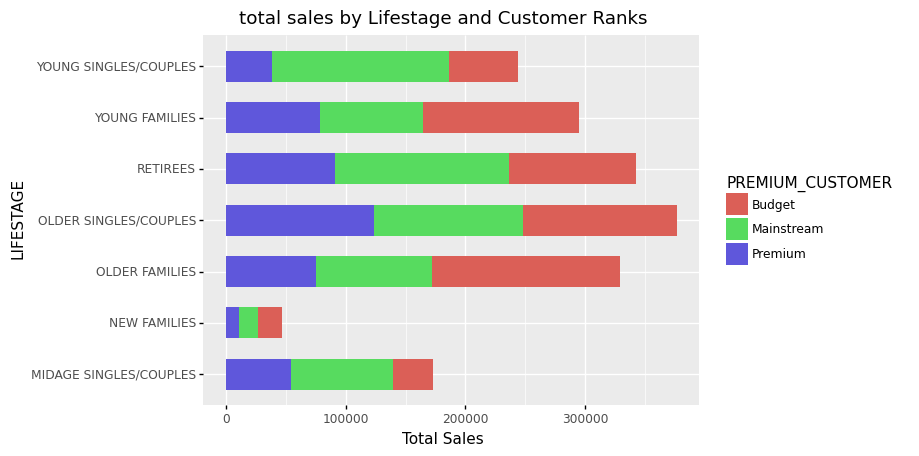

<ggplot: (136681207233)>

In [545]:
#bar plot of total sales by LIFESTAGE grouped by membership
(
    ggplot(saleTotal) +
    geom_col(width = 0.6) +
    aes(x = 'LIFESTAGE', y = 'TOT_SALES', fill = 'PREMIUM_CUSTOMER') +
    labs(y = 'Total Sales', title = 'total sales by Lifestage and Customer Ranks') +
    coord_flip()
)

Sales are coming mainly from Budget - older families, Mainstream - young
singles/couples, and Mainstream - retirees
Let's see if the higher sales are due to there being more customers who buy chips.


In [572]:
#number of customers by groups
countbyBoth = mergedData.groupby(['PREMIUM_CUSTOMER'] + ['LIFESTAGE'], as_index = False)["LYLTY_CARD_NBR"].nunique()
countbyBoth = countbyBoth.sort_values(by = 'LYLTY_CARD_NBR', ascending=False)
countbyBoth

,PREMIUM_CUSTOMER,LIFESTAGE,LYLTY_CARD_NBR
13,Mainstream,YOUNG SINGLES/COUPLES,7917
11,Mainstream,RETIREES,6358
10,Mainstream,OLDER SINGLES/COUPLES,4858
3,Budget,OLDER SINGLES/COUPLES,4849
17,Premium,OLDER SINGLES/COUPLES,4682
2,Budget,OLDER FAMILIES,4611
4,Budget,RETIREES,4385
5,Budget,YOUNG FAMILIES,3953
18,Premium,RETIREES,3812
6,Budget,YOUNG SINGLES/COUPLES,3647


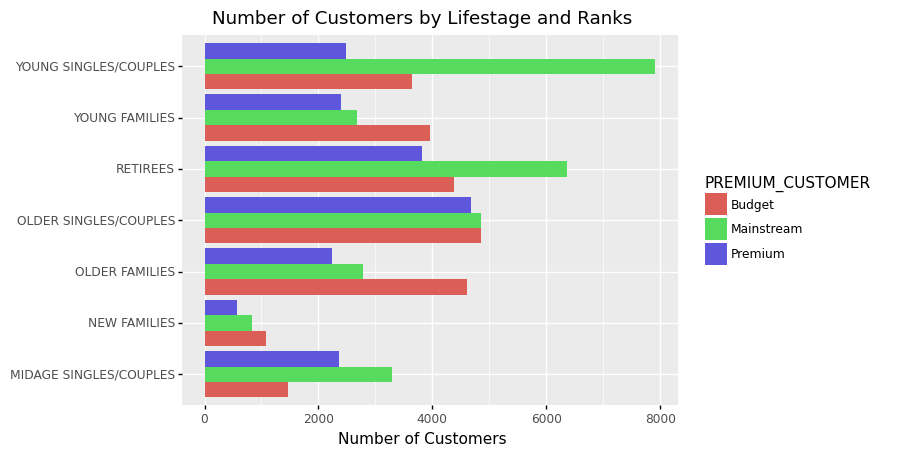

<ggplot: (136671003477)>

In [573]:
#graph of number of customers by group
(
    ggplot(countbyBoth, aes(x = 'LIFESTAGE', y = 'LYLTY_CARD_NBR', groupby = 'PREMIUM_CUSTOMER', fill = 'PREMIUM_CUSTOMER')) +
    geom_col(position = 'dodge') +
    labs(y = "Number of Customers", x = '', title = 'Number of Customers by Lifestage and Ranks') +
    coord_flip()
)

There are more Mainstream - young singles/couples and Mainstream - retirees who buy
chips. This contributes to there being more sales to these customer segments but
this is not a major driver for the Budget - Older families segment.
Higher sales may also be driven by more units of chips being bought per customer.
Let's have a look at this next.

In [494]:
#totalbyBoth = mergedData.pivot(columns = ('LIFESTAGE', 'PREMIUM_CUSTOMER'), values = 'TOT_SALES').agg('sum')

PROD_QTY_AVE = mergedData.groupby(['PREMIUM_CUSTOMER'] + ['LIFESTAGE'], as_index=False).mean().sort_values('PROD_QTY')


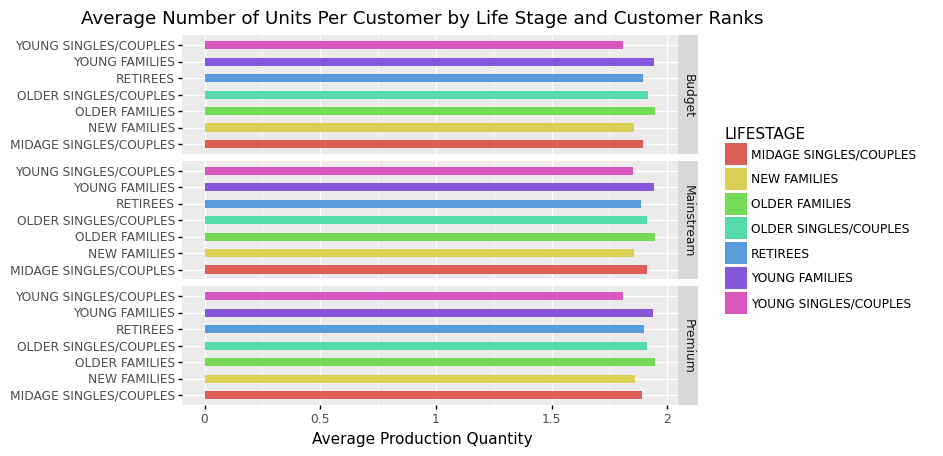

<ggplot: (136675079753)>

In [495]:
# plot the average number of units per customer by those two dimensions.
(
    ggplot(PROD_QTY_AVE) +
    #ggplot(mergedData, aes(x = 'LIFESTAGE', y = 'PROD_QTY_AVE', groupby = 'PREMIUM_CUSTOMER', fill = 'PREMIUM_CUSTOMER')) +
    geom_col(aes(x = 'LIFESTAGE' , y = 'PROD_QTY', fill = 'LIFESTAGE'), width = 0.5) +
    labs(y = "Average Production Quantity", x = '', title = 'Average Number of Units Per Customer by Life Stage and Customer Ranks') +
    facet_grid('PREMIUM_CUSTOMER ~ .') +
    coord_flip()
)

Older families and young families in general buy more chips per customer
Let's also investigate the average price per unit chips bought for each customer
segment as this is also a driver of total sales.

In [587]:
test_sample = mergedData.groupby(['PREMIUM_CUSTOMER'] + ['LIFESTAGE'], as_index=False).mean()[['PREMIUM_CUSTOMER', 'LIFESTAGE', 'PROD_QTY']]
test_sample_young = test_sample.sort_values(by = 'LIFESTAGE')[18:21]
test_sample_midage = test_sample.sort_values(by = 'LIFESTAGE')[0:3]
[test_sample_young, test_sample_midage]

[   PREMIUM_CUSTOMER              LIFESTAGE  PROD_QTY
 13       Mainstream  YOUNG SINGLES/COUPLES  1.853510
 6            Budget  YOUNG SINGLES/COUPLES  1.808002
 20          Premium  YOUNG SINGLES/COUPLES  1.807075,
    PREMIUM_CUSTOMER               LIFESTAGE  PROD_QTY
 0            Budget  MIDAGE SINGLES/COUPLES  1.893626
 14          Premium  MIDAGE SINGLES/COUPLES  1.891750
 7        Mainstream  MIDAGE SINGLES/COUPLES  1.911942]

In [597]:
mainstream = (mergedData["PREMIUM_CUSTOMER"] == "Mainstream")
lifestage_chosen = (mergedData["LIFESTAGE"] == "MIDAGE SINGLES/COUPLES") | (mergedData["LIFESTAGE"] == "YOUNG SINGLES/COUPLES")

premium_budget = (mergedData["PREMIUM_CUSTOMER"] == "Budget") | (mergedData["PREMIUM_CUSTOMER"] == "Premium")

sample_1 = mergedData[lifestage_chosen & mainstream]["TOT_SALES"]
sample_2 = mergedData[lifestage_chosen & premium_budget]["TOT_SALES"]
stat, pval = stats.ttest_ind(sample_1.values, sample_2.values, equal_var=False)

print(pval)
pval < 0.0000001

AttributeError: 'numpy.float64' object has no attribute 'ttest_ind'

Since it is two categorical varaibles with one dependent numeric variable, 
we should choose two-way ANOVA, estimating how the mean of a quantitative variable 
changes according to the levels of two categorical variables.



Mainstream midage and young singles and couples are more willing to pay more per
packet of chips compared to their budget and premium counterparts. This may be due
to premium shoppers being more likely to buy healthy snacks and when they buy
chips, this is mainly for entertainment purposes rather than their own consumption.
This is also supported by there being fewer premium midage and young singles and
couples buying chips compared to their mainstream counterparts.